In [3]:
!pip install dm-haiku

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 4.4 MB/s eta 0:00:00


In [4]:
import haiku as hk
import jax
import jax.numpy as jnp
import jax.tree_util as jtree

import numpy as np
import optax
from typing import Sequence, NamedTuple
import json

import matplotlib.pyplot as plt
import itertools

---
# Code
---
# Deep Linear Network

In [72]:
# Define the DLN model
class DeepLinearNetwork(hk.Module):
    def __init__(self, layer_widths: Sequence[int], name: str = None, with_bias=False):
        super().__init__(name=name)
        self.layer_widths = layer_widths
        self.with_bias = with_bias

    def __call__(self, x):
        for width in self.layer_widths:
            x = hk.Linear(width, with_bias=self.with_bias)(x)
        return x

# Function to initialize and apply the DLN model
def forward_fn(x, layer_widths):
    net = DeepLinearNetwork(layer_widths)
    return net(x)

# Create a Haiku-transformed version of the model
def create_model(layer_widths):
    model = hk.without_apply_rng(hk.transform(lambda x: forward_fn(x, layer_widths)))
    return model


def generate_training_data(true_param, model, input_dim, num_samples):
    # Generate random inputs uniformly from the input ball
    input_directions = np.random.normal(size=(num_samples, input_dim))
    inputs = (np.random.rand(num_samples, 1)**(1/input_dim)) * (input_directions/np.linalg.norm(input_directions, axis=-1, keepdims=True))

    # Apply the true model to generate outputs
    true_outputs = model.apply(true_param, inputs)

    return inputs, true_outputs

def mse_loss(param, model, inputs, targets):
    predictions = model.apply(param, inputs)
    return jnp.mean((predictions - targets) ** 2)

# Assuming the input distribution is sampled uniformly from the input ball, this
# will be the average of the empirical loss
def make_population_loss_fn(true_param):
    first_linear = true_param['deep_linear_network/linear']['w']
    input_dim = first_linear.shape[0]
    true_prod = np.eye(input_dim)
    for p in true_param.values():
        true_prod = true_prod @ p['w']
        output_dim = p['w'].shape[1]
    def population_loss(param):
        prod = jnp.eye(input_dim)
        for p in param.values():
            prod = prod @ p['w']
        Q = true_prod - prod
        return jnp.sum(Q*Q) / ((input_dim+2) * output_dim)
    return population_loss

def create_minibatches(inputs, targets, batch_size, shuffle=True):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    else:
        indices = np.arange(len(inputs))

    for start_idx in range(0, len(inputs) - batch_size + 1, batch_size):
        excerpt = indices[start_idx:start_idx + batch_size]
        yield inputs[excerpt], targets[excerpt]


## SGLD code

In [6]:

class SGLDConfig(NamedTuple):
  epsilon: float
  gamma: float
  num_steps: int

def generate_rngkey_tree(key_or_seed, tree_or_treedef):
    rngseq = hk.PRNGSequence(key_or_seed)
    return jtree.tree_map(lambda _: next(rngseq), tree_or_treedef)

def optim_sgld(epsilon, rngkey_or_seed):
    @jax.jit
    def sgld_delta(g, rngkey):
        eta = jax.random.normal(rngkey, shape=g.shape) * jnp.sqrt(epsilon)
        return -epsilon * g / 2 + eta

    def init_fn(_):
        return rngkey_or_seed

    @jax.jit
    def update_fn(grads, state):
        rngkey, new_rngkey = jax.random.split(state)
        rngkey_tree = generate_rngkey_tree(rngkey, grads)
        updates = jax.tree_map(sgld_delta, grads, rngkey_tree)
        return updates, new_rngkey
    return optax.GradientTransformation(init_fn, update_fn)


def create_local_logposterior(avgnegloglikelihood_fn, num_training_data, w_init, gamma, itemp):
    def helper(x, y):
        return jnp.sum((x - y)**2)

    def _logprior_fn(w):
        sqnorm = jax.tree_util.tree_map(helper, w, w_init)
        return jax.tree_util.tree_reduce(lambda a,b: a + b, sqnorm)

    def logprob(w, x, y):
        loglike = -num_training_data * avgnegloglikelihood_fn(w, x, y)
        logprior = -gamma / 2 * _logprior_fn(w)
        return itemp * loglike + logprior
    return logprob


## Compute DLN true learning coefficients

Reference:
Aoyagi, Miki. 2023. “Consideration on the Learning Efficiency Of Multiple-Layered Neural Networks with Linear Units.” https://doi.org/10.2139/ssrn.4404877.

In [7]:
def true_dln_learning_coefficient(true_rank, layer_widths, input_dim, verbose=False):
    M_list = np.array([input_dim] + list(layer_widths)) - true_rank
    indices = brute_force_search_subset(M_list, early_return=verbose)
    M_subset = M_list[indices]
    if verbose:
        print(f"M_list: {M_list}, indices: {indices}, M_subset: {M_subset}")
    M_subset_sum = np.sum(M_subset)
    ell = len(M_subset) - 1
    M = np.ceil(M_subset_sum / ell)
    a = M_subset_sum - (M - 1) * ell
    output_dim = layer_widths[-1]

    term1 = (-true_rank**2 + true_rank * (output_dim + input_dim)) / 2
    term2 = a * (ell - a) / (4 * ell)
    term3 = -ell * (ell - 1) / 4 * (M_subset_sum / ell)**2
    term4 = 1 / 2 * np.sum([M_subset[i] * M_subset[j] for i in range(ell + 1) for j in range(i + 1, ell + 1)])
    learning_coefficient = term1 + term2 + term3 + term4
    return learning_coefficient

def _condition(indices, intlist, verbose=False):
    intlist = np.array(intlist)
    ell = len(indices) - 1
    subset = intlist[indices]
    complement = intlist[[i for i in range(len(intlist)) if i not in indices]]
    has_complement = len(complement) > 0
    # print(indices, subset, complement)
    if has_complement and not (np.max(subset) < np.min(complement)):
        if verbose: print(f"max(subset) = {np.max(subset)}, min(complement) = {np.min(complement)}")
        return False
    if not (np.sum(subset) >= ell * np.max(subset)):
        if verbose: print(f"sum(subset) = {sum(subset)}, ell * max(subset) = {ell * np.max(subset)}")
        return False
    if has_complement and not (np.sum(subset) < ell * np.min(complement)):
        if verbose: print(f"sum(subset) = {sum(subset)}, ell * min(complement) = {ell * np.min(complement)}")
        return False
    return True


def generate_indices_subsets(length):
    indices = list(range(length))
    for size in range(1, length + 1):
        for subset in itertools.combinations(indices, size):
            subset = np.array(subset)
            yield subset


def brute_force_search_subset(intlist, early_return=False):
    candidates = []
    for indices in generate_indices_subsets(len(intlist)):
        if _condition(indices, intlist):
            if early_return:
                return indices
            candidates.append(indices)
    if len(candidates) == 0:
        raise RuntimeError("No candidates")
    if len(candidates) > 1:
        print("More than one candidate")
    return candidates[0]


def to_float_or_list(x):
    if isinstance(x, (float, int)):
        return float(x)
    elif isinstance(x, (list, tuple)):
        return [float(el) for el in x]
    elif hasattr(x, "tolist"):  # For JAX or numpy arrays
        return x.tolist()
    else:
        raise ValueError(f"Unsupported type {type(x)}")

def to_json_friendly_tree(tree):
    return jtree.tree_map(to_float_or_list, tree)



---
# Experiments
---
## Initialising and training network

In [116]:

layer_widths = [20, 20, 10]
input_dim = 10  # Dimension of the input
num_training_data = 10000  # Number of training samples

# Create the DLN model
model = create_model(layer_widths)

# Initialize the "true" model parameters
rngkey = jax.random.PRNGKey(0)
dummy_input = jnp.zeros((1, input_dim))
rngkey, subkey = jax.random.split(rngkey)
true_param = model.init(rngkey, dummy_input)

# Generate training data
x_train, y_train = generate_training_data(true_param, model, input_dim, num_training_data)
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
jtree.tree_map_with_path(lambda path, x: x.shape, true_param)

x_train shape: (10000, 10), y_train shape: (10000, 10)


{'deep_linear_network/linear': {'w': (10, 20)},
 'deep_linear_network/linear_1': {'w': (20, 20)},
 'deep_linear_network/linear_2': {'w': (20, 10)}}

In [117]:
# Test that MSE loss agrees with population loss
rngkey, subkey = jax.random.split(rngkey)
param = model.init(rngkey, jnp.zeros((1, input_dim)))
mse_loss(param, model, x_train, y_train), make_population_loss_fn(true_param)(param)

(Array(0.05518581, dtype=float32), Array(0.05544334, dtype=float32))

In [108]:
%%time
learning_rate = 0.1
optimizer = optax.sgd(learning_rate)
num_epochs = 100
batch_size = 500

rngkey, subkey = jax.random.split(rngkey)
param = model.init(rngkey, jnp.zeros((1, input_dim)))
opt_state = optimizer.init(param)

loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))
grad_fn = jax.jit(jax.grad(loss_fn, argnums=0))

for epoch in range(num_epochs):
    for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=batch_size):
        grads = grad_fn(param, x_batch, y_batch)
        updates, opt_state = optimizer.update(grads, opt_state)
        param = optax.apply_updates(param, updates)
    if epoch % 10 == 0:
        loss_val = mse_loss(param, model, x_train, y_train)
        print(f"Epoch {epoch}, Loss: {loss_val}")

trained_param = param

Epoch 0, Loss: 0.04907646402716637
Epoch 10, Loss: 0.011652042157948017
Epoch 20, Loss: 0.0046080551110208035
Epoch 30, Loss: 0.002085857093334198
Epoch 40, Loss: 0.0010761043522506952
Epoch 50, Loss: 0.0006160790217109025
Epoch 60, Loss: 0.0003769489121623337
Epoch 70, Loss: 0.00024003276485018432
Epoch 80, Loss: 0.0001567378785694018
Epoch 90, Loss: 0.00010415614815428853
CPU times: user 4.62 s, sys: 13 ms, total: 4.63 s
Wall time: 4.73 s


Step 200, nll: 309.3504943847656
Step 400, nll: 398.9998474121094
Step 600, nll: 364.7080078125
Step 800, nll: 352.89599609375
Step 1000, nll: 389.50018310546875
Step 1200, nll: 407.58856201171875
Step 1400, nll: 343.9736633300781
Step 1600, nll: 380.947265625
Step 1800, nll: 377.947021484375
Step 2000, nll: 353.5481262207031
Step 2200, nll: 344.7585144042969
Step 2400, nll: 374.6883544921875
Step 2600, nll: 351.78826904296875
Step 2800, nll: 354.5546875
Step 3000, nll: 368.07733154296875
Step 3200, nll: 368.3761901855469
Step 3400, nll: 351.4334716796875
Step 3600, nll: 363.7292785644531
Step 3800, nll: 353.62384033203125
Step 4000, nll: 350.010986328125
Step 4200, nll: 368.8718566894531
Step 4400, nll: 360.11761474609375
Step 4600, nll: 372.42523193359375
Step 4800, nll: 358.2378845214844
Step 5000, nll: 383.1185302734375


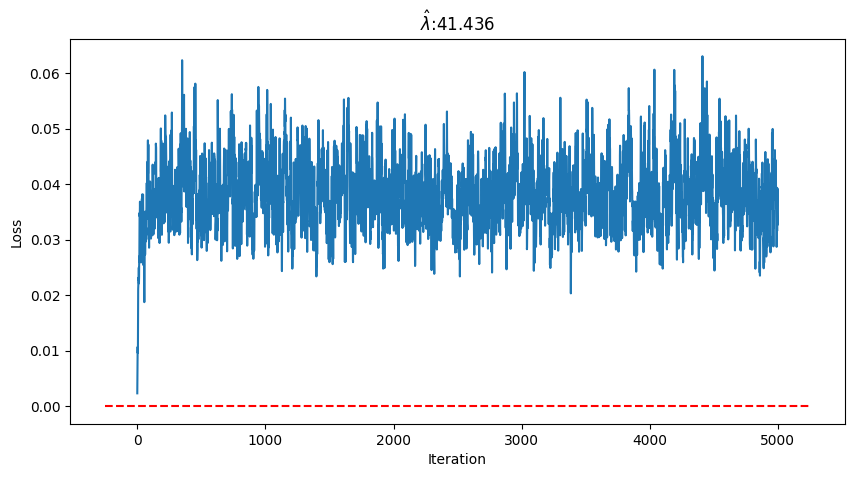

In [112]:

sgld_config = SGLDConfig(
    epsilon=1e-3,
    gamma=10.0,
    num_steps=5000,
)
itemp = 1 / np.log(num_training_data)
param_init = true_param

local_logprob = create_local_logposterior(
        avgnegloglikelihood_fn=loss_fn,
        num_training_data=num_training_data,
        w_init=param_init,
        gamma=sgld_config.gamma,
        itemp=itemp,
    )
sgld_grad_fn = jax.jit(jax.value_and_grad(lambda w, x, y: -local_logprob(w, x, y), argnums=0))


rngkey, subkey = jax.random.split(rngkey)
sgldoptim = optim_sgld(sgld_config.epsilon, rngkey)
samples = []
nlls = []
opt_state = sgldoptim.init(param_init)
param = param_init
t = 0
while t < sgld_config.num_steps:
    for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=batch_size):
        nll, grads = sgld_grad_fn(param, x_batch, y_batch)
        nlls.append(float(nll))
        updates, opt_state = sgldoptim.update(grads, opt_state)
        param = optax.apply_updates(param, updates)
        samples.append(param)
        t += 1
        if t % 200 == 0:
            print(f"Step {t}, nll: {nll}")

init_loss = loss_fn(param_init, x_train, y_train)
loss_trace = [loss_fn(p, x_train, y_train) for p in samples]
lambdahat = (np.mean(loss_trace) - init_loss) * num_training_data * itemp


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(loss_trace)
ax.set_title("$\hat{\lambda}$:" + f"{lambdahat:.3f}")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
xmin, xmax = ax.get_xlim()
ax.hlines(init_loss, xmin, xmax, colors="r", linestyles="dashed")

In [113]:
true_matrix = jnp.linalg.multi_dot(
    [true_param[f'deep_linear_network/linear{loc}']['w'] for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
)
true_rank = jnp.linalg.matrix_rank(true_matrix)
true_lambda = true_dln_learning_coefficient(true_rank, layer_widths, input_dim, verbose=True)
print(f"True matrix shape={true_matrix.shape}")
print(f"Input dim: {input_dim}")
print(f"Layer widths: {layer_widths}")
print(f"True lambda: {true_lambda}")
print(f"Estimated lambda: {lambdahat}")


M_list: [ 0 10 10  0], indices: [0 3], M_subset: [0 0]
True matrix shape=(10, 10)
Input dim: 10
Layer widths: [20, 20, 10]
True lambda: 50.0
Estimated lambda: 41.4357795715332


## Learning coefficient lower bounds

In [159]:
def pack_params(params):
    params_flat, treedef = jax.tree_util.tree_flatten(params)
    shapes = [p.shape for p in params_flat]
    indices = np.cumsum([p.size for p in params_flat])
    params_packed = jnp.concatenate([jnp.ravel(p) for p in params_flat])
    pack_info = (treedef, shapes, indices)
    return params_packed, pack_info

def unpack_params(params_packed, pack_info):
    treedef, shapes, indices = pack_info
    params_split = jnp.split(params_packed, indices)
    params_flat = [jnp.reshape(p, shape) for p, shape in zip(params_split, shapes)]
    params = jax.tree_util.tree_unflatten(treedef, params_flat)
    return params


In [174]:
# Hessian
true_param_packed, pack_info = pack_params(true_param)
loss_fn = lambda p_packed: make_population_loss_fn(true_param)(unpack_params(p_packed, pack_info))

hessian = np.asarray(jax.hessian(loss_fn)(true_param_packed))
eigvals = np.linalg.eigvalsh(hessian)

np.sum(eigvals > 0.001)

100

In [183]:
# Functional dimension
rngkey = jax.random.PRNGKey(0)
true_param_packed, pack_info = pack_params(true_param)
inputs = jax.random.normal(rngkey, (50, input_dim))
fwd_fn = lambda p_packed: jnp.ravel(model.apply(unpack_params(p_packed, pack_info), inputs))

jacobian = np.asarray(jax.jacfwd(fwd_fn)(true_param_packed))
svdvals = np.linalg.svd(jacobian, compute_uv=False)

np.sum(svdvals > 0.001)

100

## Sweeping through different DLN + true parameter

In [ ]:
len(expt_rec[0]["checkpoints_info"]), checkpoint_steps

(3, [400, 800, 1200, 1600, 2000])

In [ ]:
%%time
sgld_config = SGLDConfig(
    epsilon=1e-5,
    gamma=10.0,
    num_steps=5000,
)
num_training_data = 10000  # Number of training samples
num_epochs = 50
num_sgd_steps = num_epochs * (num_training_data // batch_size)
batch_size = 500
num_checkpoints = 5
checkpoint_freq = num_sgd_steps // num_checkpoints
checkpoint_steps = list(range(checkpoint_freq, num_sgd_steps + 1, checkpoint_freq))
print(checkpoint_steps)
itemp = 1 / np.log(num_training_data)
learning_rate = 0.01
optimizer = optax.sgd(learning_rate)


num_expt = 200
expt_rec = []
rngkey = jax.random.PRNGKey(0)
for expt_i in range(num_expt):
    # expt configs
    num_layer = np.random.randint(2, 20)
    layer_widths = list(np.random.randint(2, 30, size=num_layer))
    input_dim = np.random.randint(2, 20)

    # Random true parameters
    model = create_model(layer_widths)
    dummy_input = jnp.zeros((1, input_dim))
    rngkey, subkey = jax.random.split(rngkey)
    true_param = model.init(rngkey, dummy_input)
    x_train, y_train = generate_training_data(true_param, model, input_dim, num_training_data)
    loss_fn = jax.jit(lambda param, inputs, targets: mse_loss(param, model, inputs, targets))

    # Training network
    rngkey, subkey = jax.random.split(rngkey)
    param = model.init(rngkey, jnp.zeros((1, input_dim)))
    opt_state = optimizer.init(param)
    grad_fn = jax.jit(jax.grad(loss_fn, argnums=0))
    sgd_step_count = 0
    checkpoints = []
    for epoch in range(num_epochs):
        for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=batch_size):
            grads = grad_fn(param, x_batch, y_batch)
            updates, opt_state = optimizer.update(grads, opt_state)
            param = optax.apply_updates(param, updates)
            sgd_step_count += 1
            if sgd_step_count in checkpoint_steps:
                checkpoints.append({"sgd_step_count": sgd_step_count, "param": param, "loss_val": mse_loss(param, model, x_train, y_train), "is_true_param": False})

    checkpoints.append({"sgd_step_count": None, "param": true_param, "loss_val": mse_loss(true_param, model, x_train, y_train), "is_true_param": True})
    # SGLD sampling initialisation
    rngkey, subkey = jax.random.split(rngkey)
    sgldoptim = optim_sgld(sgld_config.epsilon, rngkey)
    for checkpoint in checkpoints:
        # initialise SGLD objective function
        param_init = checkpoint["param"]
        local_logprob = create_local_logposterior(
                avgnegloglikelihood_fn=loss_fn,
                num_training_data=num_training_data,
                w_init=param_init,
                gamma=sgld_config.gamma,
                itemp=itemp,
            )
        sgld_grad_fn = jax.jit(jax.value_and_grad(lambda w, x, y: -local_logprob(w, x, y), argnums=0)) # grad(sgld objective function)
        loss_trace = []
        nlls = []
        opt_state = sgldoptim.init(param_init)
        param = param_init
        t = 0
        # SGLD loop
        while t < sgld_config.num_steps:
            for x_batch, y_batch in create_minibatches(x_train, y_train, batch_size=batch_size):
                nll, grads = sgld_grad_fn(param, x_batch, y_batch)
                nlls.append(float(nll))
                updates, opt_state = sgldoptim.update(grads, opt_state)
                param = optax.apply_updates(param, updates)
                loss_trace.append(loss_fn(param, x_train, y_train))
                t += 1

        # compute lambdahat from loss trace
        init_loss = loss_fn(param_init, x_train, y_train)
        lambdahat = (np.mean(loss_trace) - init_loss) * num_training_data * itemp
        checkpoint.update({
            "lambdahat": lambdahat,
            "loss_trace": loss_trace,
            "nlls": nlls,
            "init_loss": init_loss,
        })

    # Computing true lambda
    true_matrix = jnp.linalg.multi_dot(
        [true_param[f'deep_linear_network/linear{loc}']['w'] for loc in [''] + [f'_{i}' for i in range(1, len(layer_widths))]]
    )
    true_matrix_assertion = np.allclose(model.apply(true_param, x_train), x_train @ true_matrix, atol=1e-4)
    true_rank = jnp.linalg.matrix_rank(true_matrix)
    true_lambda = true_dln_learning_coefficient(true_rank, layer_widths, input_dim, verbose=True)

    # recording experiment
    for checkpoint in checkpoints:
        checkpoint["param"] = jtree.tree_map(lambda x: x.shape, checkpoint["param"])

    rec = {
            "expt_id": expt_i,
            "num_layer": num_layer,
            "layer_widths": layer_widths,
            "input_dim": input_dim,
            "true_matrix_assertion": true_matrix_assertion,
            "true_lambda": true_lambda,
            "true_rank": true_rank,
            "true_matrix_shape": true_matrix.shape,
            "checkpoints_info": checkpoints
        }
    expt_rec.append(to_json_friendly_tree(rec))
    checkpoint_lambdahats = [float(c["lambdahat"]) for c in checkpoints]
    print(
        f"Expt: {expt_i}, "
        f"True matrix shape={true_matrix.shape}, "
        f"Input dim: {input_dim}, "
        f"Layer widths: {layer_widths}, "
        f"True lambda: {true_lambda}, "
        f"Estimated lambda: {checkpoint_lambdahats}, "
    )


all([rec["true_matrix_assertion"] for rec in expt_rec])

[200, 400, 600, 800, 1000]
M_list: [11  1  7  7 24  5  5 24 13 15  9  1 16 10  8 26 21  0], indices: [ 1 11 17], M_subset: [1 1 0]
Expt: 0, True matrix shape=(14, 3), Input dim: 14, Layer widths: [4, 10, 10, 27, 8, 8, 27, 16, 18, 12, 4, 19, 13, 11, 29, 24, 3], True lambda: 21.0, Estimated lambda: [25.33820152282715, 25.42129135131836, 25.470809936523438, 25.461849212646484, 25.420900344848633, 23.52928352355957], 
M_list: [ 5  5 25 16  2 24  8  0 24 11 13  3 23 14 23 19 13], indices: [4 7], M_subset: [2 0]
Expt: 1, True matrix shape=(9, 17), Input dim: 9, Layer widths: [9, 29, 20, 6, 28, 12, 4, 28, 15, 17, 7, 27, 18, 27, 23, 17], True lambda: 44.0, Estimated lambda: [14.444180488586426, 15.580073356628418, 36.59414291381836, 38.16774368286133, 41.15164566040039, 48.041194915771484], 
M_list: [ 0  8  8 11 22 18  0 15  4  1  0], indices: [ 0  6 10], M_subset: [0 0 0]
Expt: 2, True matrix shape=(7, 7), Input dim: 7, Layer widths: [15, 15, 18, 29, 25, 7, 22, 11, 8, 7], True lambda: 24.5, E

True

In [ ]:
import pandas as pd
import seaborn as sns

data = []
header = [
    "expt_id", "num_layer", "layer_widths", "input_dim",
    "true_lambda", "true_rank", "true_matrix_shape"
]
header_rest = [
    "sgd_step_count", "loss_val", "is_true_param",
    "lambdahat", "init_loss",
]
for rec in expt_rec:
    extract = [rec[key] for key in header]
    for checkpoint in rec["checkpoints_info"]:
        data.append(
            extract + [checkpoint[key] for key in header_rest]
        )
df_data = pd.DataFrame(data, columns=header + header_rest)
df_data["is_true_param"] = np.array(df_data["is_true_param"], dtype=bool)
model_dims = []
for i, row in df_data.iterrows():
    widths = [row["input_dim"]] + list(row["layer_widths"])
    model_dim = np.sum([widths[i] * widths[i + 1] for i in range(len(widths) - 1)])
    model_dims.append(model_dim)
df_data["model_dim"] = model_dims

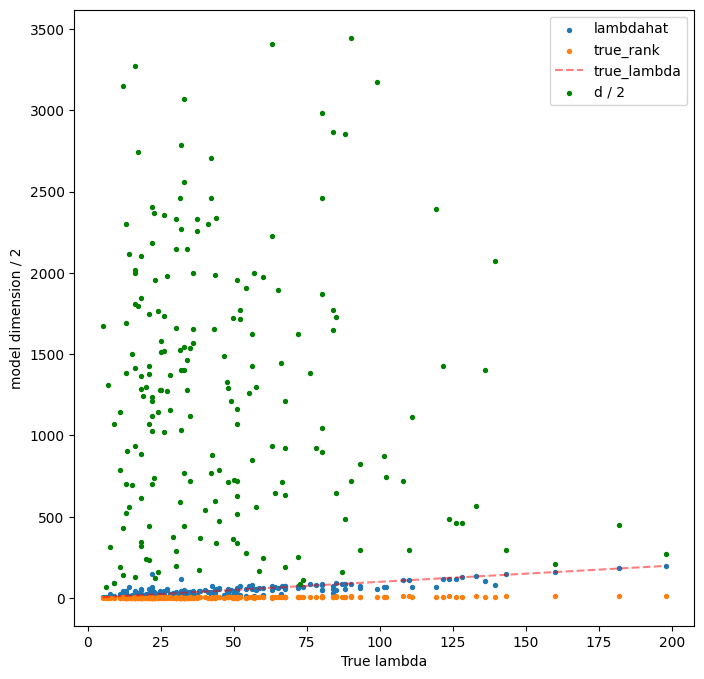

In [ ]:

df = df_data[df_data["is_true_param"]]
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df["true_lambda"], df["lambdahat"], s=8, label="lambdahat")
ax.scatter(df["true_lambda"], df["true_rank"], s=8, label="true_rank")
sorted_true_lambda = sorted(df["true_lambda"])
ax.plot(sorted_true_lambda, sorted_true_lambda, label="true_lambda", linestyle="dashed", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("True lambda")
ax.set_ylabel("metric")

# ax = ax.twinx()
ax.scatter(df["true_lambda"], df["model_dim"] / 2, s=8, label="d / 2", color="g")
ax.set_ylabel("model dimension / 2")
# ax.set_yscale("log")
ax.legend(loc="upper right")

# ax.set_title("True vs estimated lambda");
# fig.savefig("./outputs/images/random_dln_lambda_vs_otherinfo_20231209.png")

Text(0, 0.5, 'lambdahat')

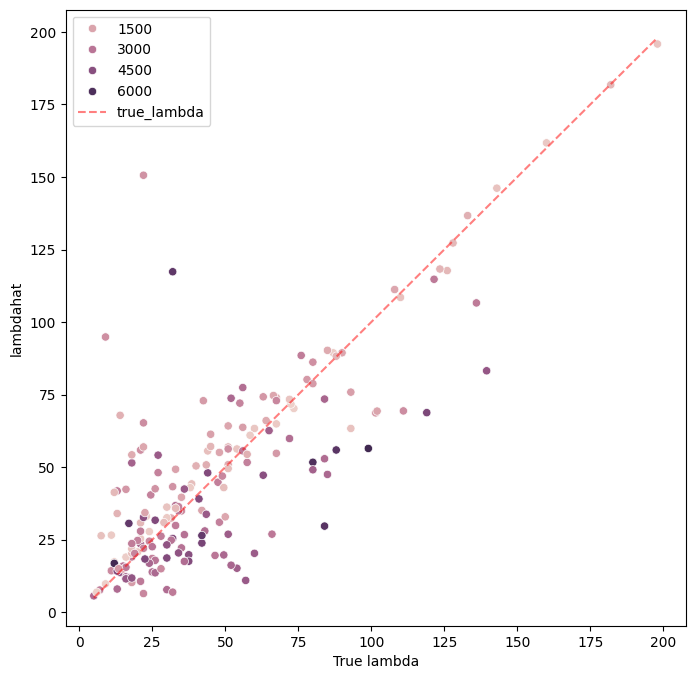

In [ ]:

df = df_data[df_data["is_true_param"]]
fig, ax = plt.subplots(figsize=(8, 8))

sns.scatterplot(
    data=df,
    x="true_lambda",
    y="lambdahat",
    hue="model_dim",
    # hue="num_layer",
    # size="true_rank",
)
sorted_true_lambda = sorted(df["true_lambda"])
ax.plot(sorted_true_lambda, sorted_true_lambda, label="true_lambda", linestyle="dashed", color="red", alpha=0.5)
ax.legend()
ax.set_xlabel("True lambda")
ax.set_ylabel("lambdahat")
# ax.set_xscale("log")
# ax.set_yscale('log')

# fig.savefig("./outputs/images/random_dln_lambda_vs_otherinfo_20231209_sns.png")

In [ ]:
df_data

,expt_id,num_layer,layer_widths,input_dim,true_lambda,true_rank,true_matrix_shape,sgd_step_count,loss_val,is_true_param,lambdahat,init_loss,model_dim
0,0.0,17.0,"[4, 10, 10, 27, 8, 8, 27, 16, 18, 12, 4, 19, 1...",14.0,21.0,3,"(14.0, 3.0)",200.0,0.000887,False,25.338202,0.000887,3499.0
1,0.0,17.0,"[4, 10, 10, 27, 8, 8, 27, 16, 18, 12, 4, 19, 1...",14.0,21.0,3,"(14.0, 3.0)",400.0,0.000851,False,25.421291,0.000851,3499.0
2,0.0,17.0,"[4, 10, 10, 27, 8, 8, 27, 16, 18, 12, 4, 19, 1...",14.0,21.0,3,"(14.0, 3.0)",600.0,0.000832,False,25.470810,0.000832,3499.0
3,0.0,17.0,"[4, 10, 10, 27, 8, 8, 27, 16, 18, 12, 4, 19, 1...",14.0,21.0,3,"(14.0, 3.0)",800.0,0.000823,False,25.461849,0.000823,3499.0
4,0.0,17.0,"[4, 10, 10, 27, 8, 8, 27, 16, 18, 12, 4, 19, 1...",14.0,21.0,3,"(14.0, 3.0)",1000.0,0.000817,False,25.420900,0.000817,3499.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,199.0,15.0,"[13, 13, 4, 15, 14, 14, 11, 16, 29, 8, 28, 7, ...",14.0,66.0,4,"(14.0, 23.0)",400.0,0.043884,False,10.721354,0.043884,2889.0
1196,199.0,15.0,"[13, 13, 4, 15, 14, 14, 11, 16, 29, 8, 28, 7, ...",14.0,66.0,4,"(14.0, 23.0)",600.0,0.043485,False,11.063796,0.043485,2889.0
1197,199.0,15.0,"[13, 13, 4, 15, 14, 14, 11, 16, 29, 8, 28, 7, ...",14.0,66.0,4,"(14.0, 23.0)",800.0,0.043194,False,11.273157,0.043194,2889.0
1198,199.0,15.0,"[13, 13, 4, 15, 14, 14, 11, 16, 29, 8, 28, 7, ...",14.0,66.0,4,"(14.0, 23.0)",1000.0,0.042940,False,11.564322,0.042940,2889.0


Text(0, 0.5, 'metric')

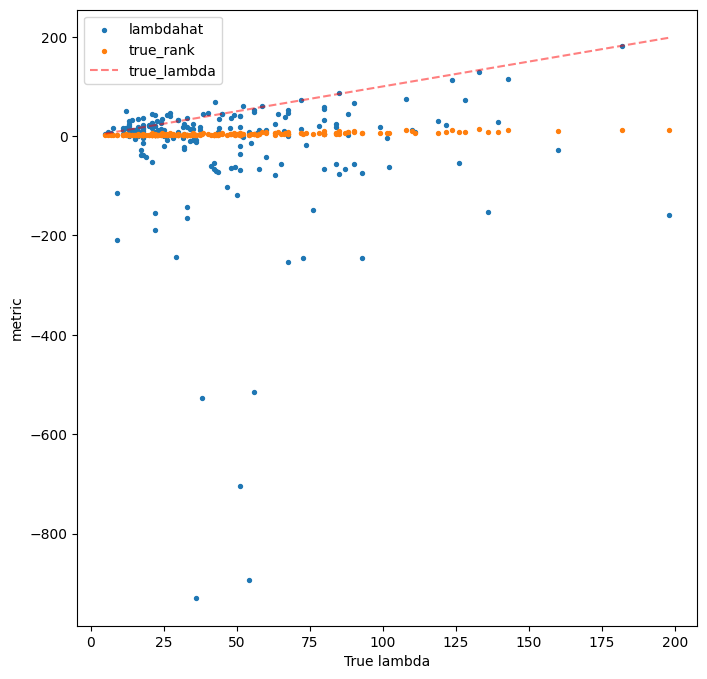

In [ ]:
# df = df_data[~df_data["is_true_param"]]
df = df_data
df = df[df["sgd_step_count"] == 400]
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df["true_lambda"], df["lambdahat"], s=8, label="lambdahat")
ax.scatter(df["true_lambda"], df["true_rank"], s=8, label="true_rank")
# ax.scatter(df["true_lambda"], df["model_dim"] / 2, s=8, label="d / 2")
sorted_true_lambda = sorted(df["true_lambda"])
ax.plot(sorted_true_lambda, sorted_true_lambda, label="true_lambda", linestyle="dashed", color="red", alpha=0.5)
ax.legend()

ax.set_xlabel("True lambda")
ax.set_ylabel("metric")
# ax.set_title("True vs estimated lambda");

---
# MISC + Tests
---

In [ ]:
np.allclose(model.apply(true_param, x_train), x_train @ true_matrix, atol=1e-5)

True

In [ ]:
# a for loop to randomly generate Ms and see how many subset passes _condition
passes = {}
for _ in range(100):
    Ms = np.random.randint(0, 100, size=10)
    if tuple(Ms) in passes:
        continue
    passes[tuple(Ms)] = []
    for indices in generate_indices_subsets(len(Ms)):
        if _condition(indices, Ms):
            passes[tuple(Ms)].append(indices)

np.unique([len(val) for val in passes.values()], return_counts=True)

(array([1]), array([100]))